# Gilbert Crew: Final Studio Analysis

In [1]:
#Importing neccesary packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from math import sqrt

### Recomendation #1: Movie Length

In this section we used statistical analysis to find out if there was correlation between movie length (minutes) and the top 100 best rated movies.

We wanted to see if the difference in means between our sample of top rated movies and the population of movies on IMDB was significant so we decided to use a 1 tail T-test. 

In [2]:
#Loaded in relevant files from IMDB for main analysis
directors_file = "files/imbd_files/directors.csv"
known_for_file= "files/imbd_files/known_for.csv"
movie_akas_file = "files/imbd_files/movie_akas.csv"
movie_basics_file = "files/imbd_files/movie_basics.csv"
movie_ratings_file= "files/imbd_files/movie_ratings.csv"
persons_file = "files/imbd_files/persons.csv"
principals_file= "files/imbd_files/principals.csv"
writers_file = "files/imbd_files/writers.csv"
# read files into dataframes
directors = pd.read_csv(directors_file)
known_for = pd.read_csv(known_for_file)
movie_akas = pd.read_csv(movie_akas_file)
movie_basics = pd.read_csv(movie_basics_file)
movie_ratings = pd.read_csv(movie_ratings_file)
persons = pd.read_csv(persons_file)
principals = pd.read_csv(principals_file)
writers = pd.read_csv(writers_file)

In [8]:
#visualizing the data
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [7]:
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [6]:
# merged movie ratings with movie basics
movie_info = pd.merge(movie_basics, movie_ratings, how="inner", on='movie_id')

In [11]:
#Checking to see if there were Null values
movie_info.isnull().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
numvotes              0
dtype: int64

In [13]:
#displaying info
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.1+ MB


In [14]:
# movies sort by most votes and avereage rating
top_movies = movie_info.sort_values(by=['numvotes', 'averagerating'], ascending=False)
# top 100 movies selected
top_100_movies = top_movies.iloc[:100]
# top 100 movies sorted specifically by movie rating
top_100_movies = top_100_movies.sort_values(by='averagerating', ascending=False)
#index reseted for top 100 movies
top_100_movies = top_100_movies.reset_index().drop(columns='index')
# select columns renamed for consistency among columns
top_100_movies = top_100_movies.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})

bottom_movies = movie_info.sort_values(by=['numvotes', 'averagerating'], ascending=True)
# Worst 100 movies
bottom_100_movies = bottom_movies.iloc[:100]
# Bottom 100 movies sorted specifically by movie rating
bottom_100_movies = bottom_100_movies.sort_values(by='averagerating', ascending=True)
#index reseted for bottom 100 movies
bottom_100_movies = bottom_100_movies.reset_index().drop(columns='index')
# select columns renamed for consistency among columns
bottom_100_movies = bottom_100_movies.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})

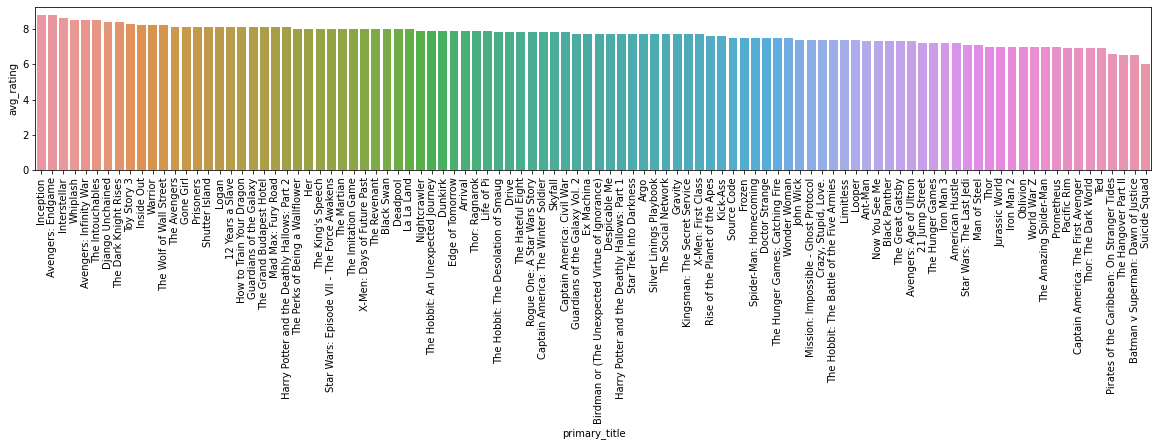

In [16]:
# graph of top 100 movies 
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
sns.barplot(x=top_100_movies.primary_title, y=top_100_movies.avg_rating);

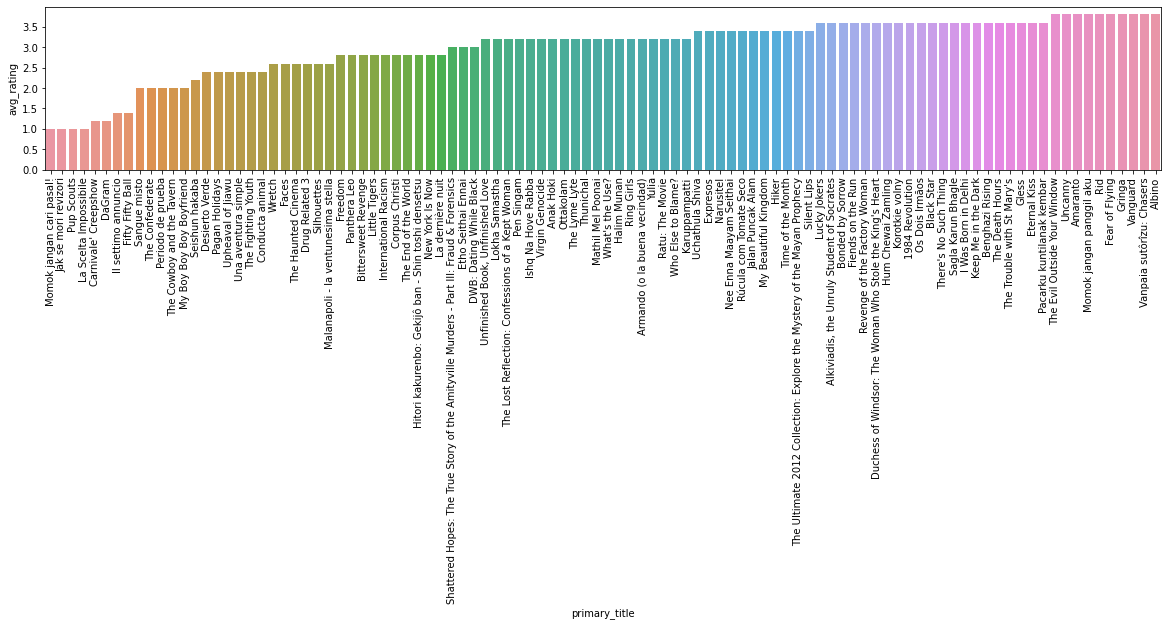

In [17]:
#Bottom 100 movies 
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
sns.barplot(x=bottom_100_movies.primary_title, y=bottom_100_movies.avg_rating);

In [18]:
#adding a new variable 'movies' to manipulate
movies = top_movies.sort_values(by='averagerating', ascending=False)
movies = top_movies.reset_index().drop(columns='index')
movies = top_movies.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})

In [19]:
#dropping columns that arent needed for analysis
movies.drop(labels=['primary_title', 'original_title', 'start_year', 'movie_id', 'genres', 'num_votes'], axis=1)

,runtime_minutes,avg_rating
2387,148.0,8.8
2241,164.0,8.4
280,169.0,8.6
12072,165.0,8.4
325,143.0,8.1
...,...,...
73137,75.0,1.2
25026,85.0,1.0
63570,NaN,1.0
70740,72.0,1.0


From here, we know that the info we want to look at contains Null values. Because of this, we must clean the data for proper analysis. There are few factors for how we proceeded:

* We decided to drop the Null values in 'runtime_minutes' 
* If we replaced 'NaN' with the average our analysis would be similar but not truthful of actual runtime
* Used dropna to remove data

In [20]:
#dropping 'Null' values
movies.dropna(axis=0, subset=['runtime_minutes'], inplace=True)

In [21]:
#creates df with just the data we need
cleaned_movies = movies['runtime_minutes']

In [23]:
#getting rid of outliers 
np.percentile(cleaned_movies, [1, 50, 99.4])

array([ 45.,  91., 170.])

In [26]:
#created a variable to hold the outlier free dataset
good_data = cleaned_movies[(cleaned_movies < 170) & (cleaned_movies > 45)]

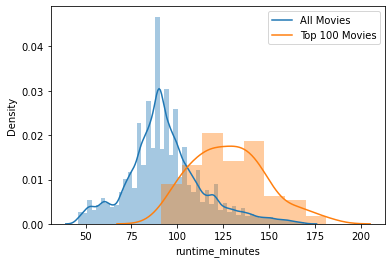

In [34]:
#Plotting all movies vs top 100 based on runtime
sns.distplot(good_data)
sns.distplot(top_100_movies['runtime_minutes'])
plt.legend(labels=(['All Movies','Top 100 Movies']));

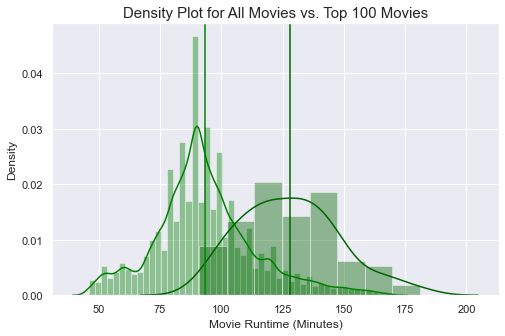

In [35]:
sns.color_palette("light:#5A9", as_cmap=True)
runcolor =top_100_movies['runtime_minutes']
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,5)})
sns.distplot(good_data, color='Green')
sns.distplot(top_100_movies['runtime_minutes'], color='DarkGreen')#31a354
plt.xlabel("Movie Runtime (Minutes)", size=12)
plt.title("Density Plot for All Movies vs. Top 100 Movies", size=15)
plt.axvline(x=good_data.mean(), color='Green')
plt.axvline(x=runcolor.mean(), color='DarkGreen');

Statistical test:

* Determined that one tail t-test would be the most beneficial
* Testing to see if the top 100 movies runtime is statistically significant

Null and Alt Hypothesis:

* Movie run time has no affect on movie ratings (null)
* Movie run time has an affect on movie ratings (alternative)


In [37]:
sd = np.std(top_100_movies['runtime_minutes'], ddof=1)
mu = cleaned_movies.mean()
x_bar = top_100_movies['runtime_minutes'].mean()
n = 100
df = 99
alpha= 0.05
print('The standard deviation of the sample =', sd)
print('The mean of the population =', mu)
print('The mean of the sample is =', x_bar)
print('The number of observations is =', n)

The standard deviation of the sample = 20.002270073189397
The mean of the population = 94.6540400990398
The mean of the sample is = 127.99
The number of observations is = 100


In [38]:
#Used to find our observed t-statistic
t_stat= (x_bar -  mu)/(sd/np.sqrt(n))
t_stat

16.666088288470306

In [40]:
#Critical T-value which is the baseline our tstat needs to be to not accept Null under our .05 alpha
t_crit = st.t.ppf(1 - 0.05, df=99)
t_crit

1.6603911559963895

In [41]:
#shows that our alpha of .05 is correct
st.t.cdf(t_crit, df=99)

0.9499999999979238

In [42]:
#Re-affirms findings that we reject Null
p_value = st.t.sf(t_stat, df=99)
p_value

8.619752364999059e-31

### Graph below shows that we can reject the null hypothesis at a significance level of 0.05


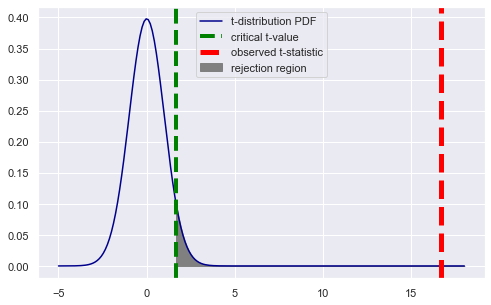

In [43]:
fig, ax = plt.subplots(figsize=(8,5))

x = np.linspace(-5, 18, 200)
y = st.t.pdf(x, df, 0, 1)

ax.plot(x, y, color='darkblue', label="t-distribution PDF")
ax.axvline(t_crit,color='green',linestyle='--',lw=4,label='critical t-value')
ax.fill_betweenx(y,x,t_crit,where=x > t_crit,color="gray",label="rejection region")
ax.axvline(t_stat, color='Red', linestyle='--', lw=5,label='observed t-statistic')

ax.legend();

#### Our findings indicate that there is a correlation between movie run time and movie ratings and if Computing Vision can get there runtime to around 127 minutes reviews are likely to be better!